### In this notebook we compare partial least squares regressions for predicting 'fam_or_subfam', which employ both PCA and multilinear regression methods. We find that no values for the number of components in the PCA part give good $r^2$ values, indicating that linear regression methods are not suitable for our data.

In [1]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import TruncatedSVD

In [2]:
#Import the data file containing all features and classifications
df = pd.read_csv('MLNS_05292024.csv')

/var/folders/5z/7fkzpcz93gz6mqgh9vjgfymm0000gn/T/ipykernel_22088/1949999970.py:2: DtypeWarning: Columns (25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MLNS_05292024.csv')


In [91]:
#Store a dataframe in X which contains all features
df_temp=df['mfcc_'+str(0)+'_avg']
df_temp=df_temp.rename('blah')
for n in range(0,40):
    df_temp=pd.concat([df_temp, df['mfcc_'+str(n)+'_avg']], axis=1)
for n in range(0,40):
    df_temp=pd.concat([df_temp, df['mfcc_'+str(n)+'_var']], axis=1)
for n in range(0,40):
    df_temp=pd.concat([df_temp, df['hs_mfcc_'+str(n)+'_avg']], axis=1)
for n in range(0,40):
    df_temp=pd.concat([df_temp, df['hs_mfcc_'+str(n)+'_var']], axis=1)
df_temp=pd.concat([df_temp, df['main_freq']], axis=1)
df_temp=pd.concat([df_temp, df['range']], axis=1)
df_temp=pd.concat([df_temp, df['max_mean']], axis=1)
df_temp=pd.concat([df_temp, df['peak_freq']], axis=1)
X=df_temp.drop(columns=['blah'])

In [92]:
#Store a series in Y which contains the classification label 'fam_or_subfam'
y=df['fam_or_subfam']

In [93]:
#Create a test-train split and train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=.2, stratify=y)
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size=.2, stratify=y_train)

In [94]:
#Converts a series containing 'fam_or_subfam' values into a dataFrame with 1s and 0s so that linear regression methods can be applied.
def fam_to_num(ser):
    temp = pd.DataFrame(0, index=ser.index, columns=['Gryllinae', 'Conocephalinae', 'Oecanthinae',
            'Phaneropterinae', 'Trigonidiinae', 'Nemobiinae', 'Hapithinae', 
            'Mogoplistinae', 'Tettigoniinae', 'Pseudophyllinae', 'Cicadidae',
            'Gryllotalpidae', 'Eneopterinae', 'Phalangopsidae', 'Listroscelidinae'])
    for i in ser.index:
        temp.at[i,ser[i]] = 1
    return temp  

In [122]:
#Computes a PLSRegression on the training set and records the r2 value on the training data and validation data.
component_max = 160
train_r2 = pd.Series(0, index=np.arange(1,component_max+1))
val_r2 = pd.Series(0, index=np.arange(1,component_max+1))

for n in range(5,component_max,10):
    plsr_pipe = Pipeline([('scale', StandardScaler()), ('plsr',PLSRegression(n_components=n, scale=False))])
    plsr_pipe.fit(X_tt.values, fam_to_num(y_tt).values)
    pred = plsr_pipe.predict(X_val.values)
    pred_tt = plsr_pipe.predict(X_tt.values)
    plsr_coef = plsr_pipe['plsr'].coef_
    val_r2[n] = r2_score(np.argmax(fam_to_num(y_val).values,axis=1), np.argmax(pred,axis=1))
    train_r2[n] = r2_score(np.argmax(fam_to_num(y_tt).values,axis=1), np.argmax(pred_tt,axis=1))

/var/folders/5z/7fkzpcz93gz6mqgh9vjgfymm0000gn/T/ipykernel_22088/39679615.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.11742576446323194' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_r2[n] = r2_score(np.argmax(fam_to_num(y_val).values,axis=1), np.argmax(pred,axis=1))
/var/folders/5z/7fkzpcz93gz6mqgh9vjgfymm0000gn/T/ipykernel_22088/39679615.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.14558386398700307' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_r2[n] = r2_score(np.argmax(fam_to_num(y_tt).values,axis=1), np.argmax(pred_tt,axis=1))


### Below we plot the $r^2$ values from above. We see that partial least squares regression is not a particularly good model, even when using all of our features.

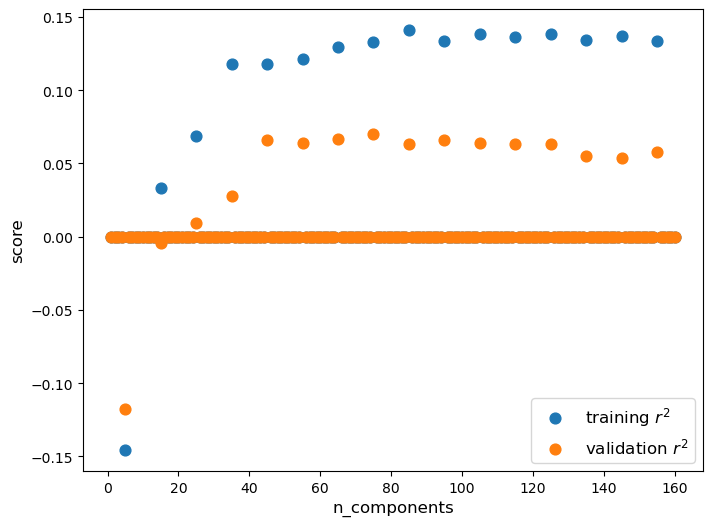

In [123]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(1,component_max+1), 
                train_r2.values,
                s = 60,
                label=r'training $r^2$')

plt.scatter(np.arange(1,component_max+1), 
                val_r2.values,
                s = 60,
                label=r'validation $r^2$')


plt.xlabel("n_components", fontsize=12)
plt.ylabel("score", fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [170]:
from sklearn.svm import SVC

train_r2 = []
val_r2 = []
component_list=[]
c_list = []

train_score_space = []
test_score_space = []

n_range = range(5, 100, 10)
c_range = [5,10, 20,50,100]
for n in n_range:
    for c in c_range:
        component_list.append(n)
        c_list.append(c)
        knn_pipe = Pipeline([('scale', StandardScaler()), ("svd", TruncatedSVD(n_components=n)), ('svc_rbf',SVC(kernel='rbf', C=c))])
        knn_pipe.fit(X_train, y_train)
        pred = knn_pipe.predict(X_train)
        train_r2.append(accuracy_score(y_train,pred))
        pred = knn_pipe.predict(X_val)
        val_r2.append(accuracy_score(y_val,pred))

c_space = np.reshape(c_list, (len(n_range), len(c_range)))
n_space = np.reshape(component_list,(len(n_range), len(c_range)))
train_score_space = np.reshape(train_r2,  (len(n_range), len(c_range)))
val_score_space = np.reshape(val_r2,  (len(n_range), len(c_range)))


In [171]:
train_score_space

array([[0.53019708, 0.54269972, 0.5558381 , 0.57279085, 0.5876245 ],
       [0.77262132, 0.82305573, 0.86692096, 0.904217  , 0.93028184],
       [0.85738504, 0.90230981, 0.93515575, 0.96185633, 0.97372325],
       [0.88641661, 0.92773893, 0.95634668, 0.97626616, 0.98749735],
       [0.90294554, 0.94681076, 0.96990888, 0.9864378 , 0.99406654],
       [0.9203221 , 0.9591015 , 0.97647807, 0.99152363, 0.99745709],
       [0.93473193, 0.96567069, 0.98241153, 0.995338  , 0.99830473],
       [0.94320831, 0.96969697, 0.98728544, 0.99703327, 0.99872854],
       [0.94617504, 0.97393516, 0.9908879 , 0.99809282, 0.99936427],
       [0.95083704, 0.97965671, 0.99300699, 0.99894045, 0.99936427]])

In [172]:
val_score_space

array([[0.53601695, 0.54766949, 0.55826271, 0.57415254, 0.58898305],
       [0.77012712, 0.81673729, 0.86228814, 0.89300847, 0.92690678],
       [0.8559322 , 0.89194915, 0.92690678, 0.96292373, 0.97351695],
       [0.88771186, 0.92266949, 0.95868644, 0.97987288, 0.9904661 ],
       [0.90148305, 0.94597458, 0.97139831, 0.98622881, 0.99576271],
       [0.91737288, 0.95868644, 0.97563559, 0.99258475, 0.99894068],
       [0.93538136, 0.97139831, 0.98305085, 0.99470339, 0.99894068],
       [0.9470339 , 0.97457627, 0.98728814, 0.99788136, 0.99894068],
       [0.95021186, 0.97563559, 0.98728814, 0.99894068, 0.99894068],
       [0.95127119, 0.97987288, 0.9904661 , 0.99894068, 0.99894068]])

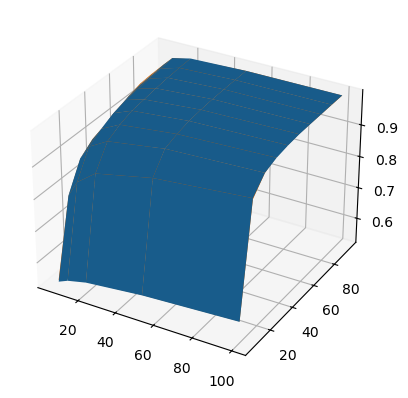

In [173]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(c_space, n_space, train_score_space)
ax.plot_surface(c_space, n_space, val_score_space)

In [ ]:
# from the figure above, we decided the optimal model has n == ? , c ==?
# so we use these two tuned parameters in the pipeline, and predict on the test data
# below is the test score

Text(0, 0.5, ' score r2')

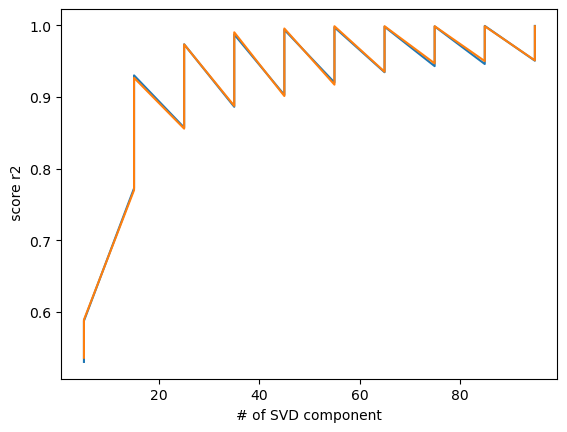

In [174]:
plt.plot(component_list, train_r2,label='train')
plt.plot(component_list, val_r2,label='test')
plt.xlabel('# of SVD component')
plt.ylabel(' score r2')

In [ ]:
knn_pipe = Pipeline([('scale', StandardScaler()), ('svc_rbf',SVC(kernel='rbf', C=10))])
knn_pipe.fit(X_train, y_train)
pred = knn_pipe.predict(X_train)
train_r2.append(accuracy_score(y_train,pred))
pred = knn_pipe.predict(X_val)
val_r2.append(accuracy_score(y_val,pred))